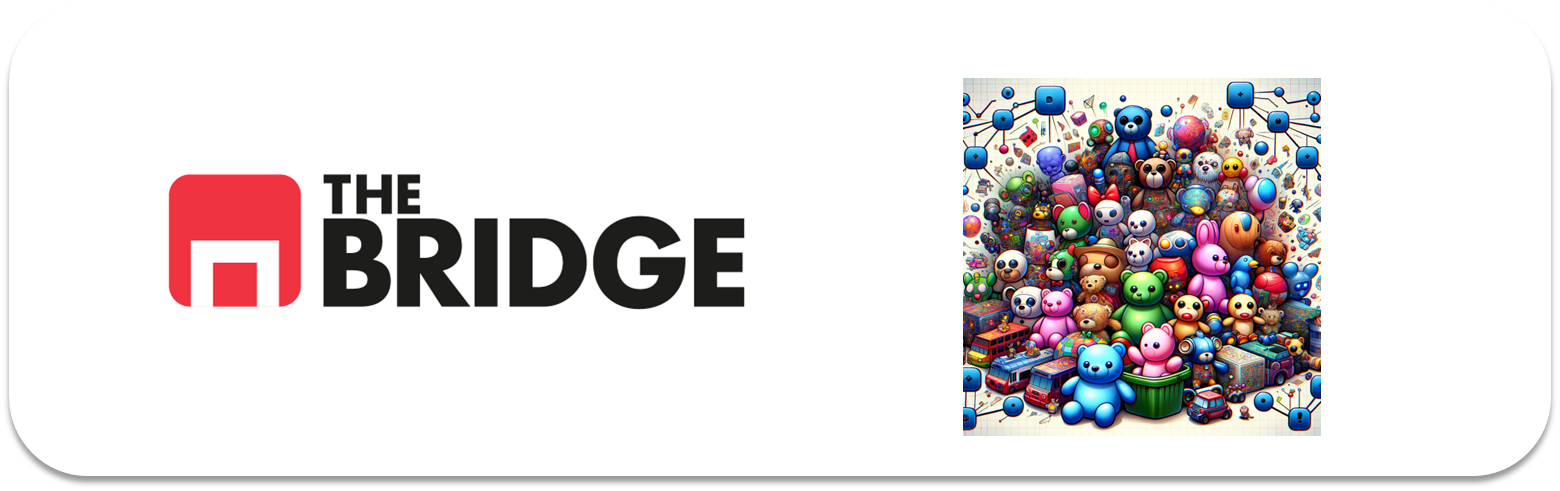

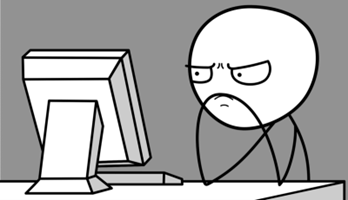

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
# Common imports
import numpy as np
import pandas as pd  # 
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Clustering
from sklearn.cluster import DBSCAN, AgglomerativeClustering  # Algoritmos de clustering
from sklearn.preprocessing import StandardScaler  # Para normalizar los datos antes del clustering
from scipy.cluster.hierarchy import dendrogram, linkage  # Para clustering jerárquico


### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [2]:

# Ruta
file_path = r"C:\Users\migue\Documents\GitHub\ONLINE_DS_THEBRIDGE_Miguel_repo_test\Sprint_13\Unidad_02\Practica_Obligatoria\data\empowering_drinks.csv"

# Cargar los datos
df_empowering = pd.read_csv(file_path)

# Crear una copia 
df = df_empowering.copy()

# Separar las columnas correctamente
columns = ["Azúcares", "Vitaminas_B", "Cafeína", "Ácido_Cítrico", "Taurina"]
df[columns] = df.iloc[:, 0].str.split('|', expand=True).astype(float)

# Eliminar la columna original con los valores concatenados
df.drop(columns=df.columns[0], inplace=True)

# Ver estadísticas descriptivas de los datos
print("Estadísticas descriptivas:")
print(df.describe())

# Ver tipos de datos de cada columna
print("\nTipos de datos:")
print(df.dtypes)

# Mostrar los primeros registros
print("\nPrimeras 30 filas:")
print(df.head(30))


Estadísticas descriptivas:
         Azúcares  Vitaminas_B     Cafeína  Ácido_Cítrico     Taurina
count  153.000000   153.000000  153.000000     153.000000  153.000000
mean     0.019231     0.037273    0.041057       0.080022   -0.044088
std      1.026182     0.995984    1.040928       1.009450    0.934399
min     -2.434235    -3.679162   -1.695971      -1.493188   -1.634288
25%     -0.816038    -0.499016   -1.043392      -0.738463   -0.799428
50%      0.061000    -0.023821    0.211566      -0.165254   -0.154899
75%      0.876275     0.707247    0.894264       0.917474    0.493956
max      2.259772     3.156325    3.062832       2.971473    2.431870

Tipos de datos:
Azúcares         float64
Vitaminas_B      float64
Cafeína          float64
Ácido_Cítrico    float64
Taurina          float64
dtype: object

Primeras 30 filas:
    Azúcares  Vitaminas_B   Cafeína  Ácido_Cítrico   Taurina
0   1.518613     0.232053  1.034819       1.013009  0.251717
1   0.246290    -0.827996  0.733629       0.9

MINI EDA

<Figure size 1200x600 with 0 Axes>

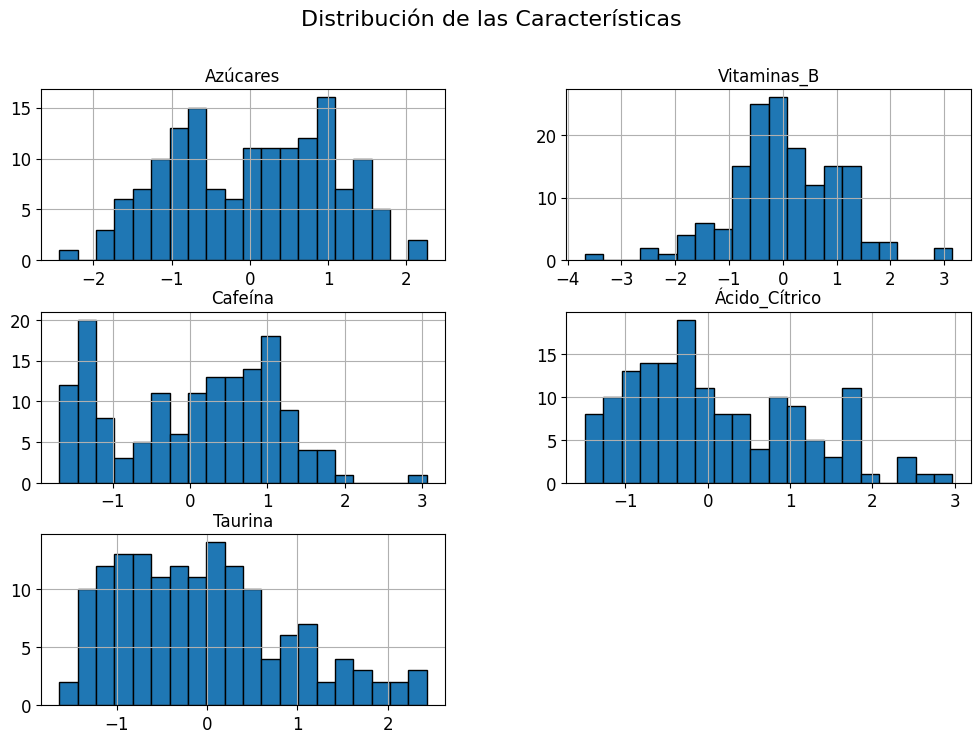

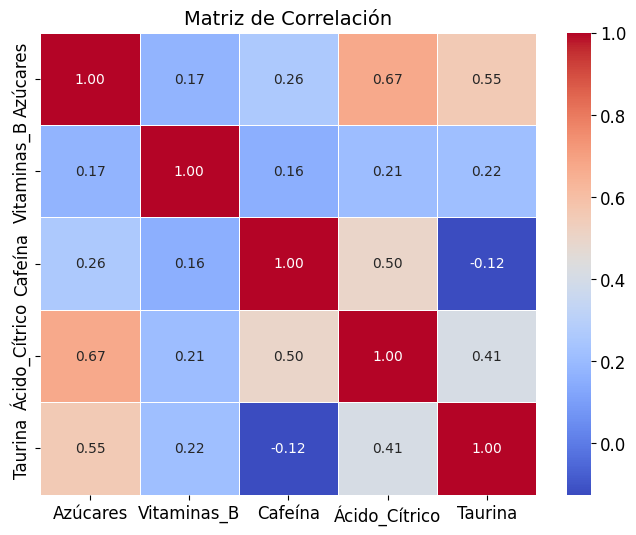

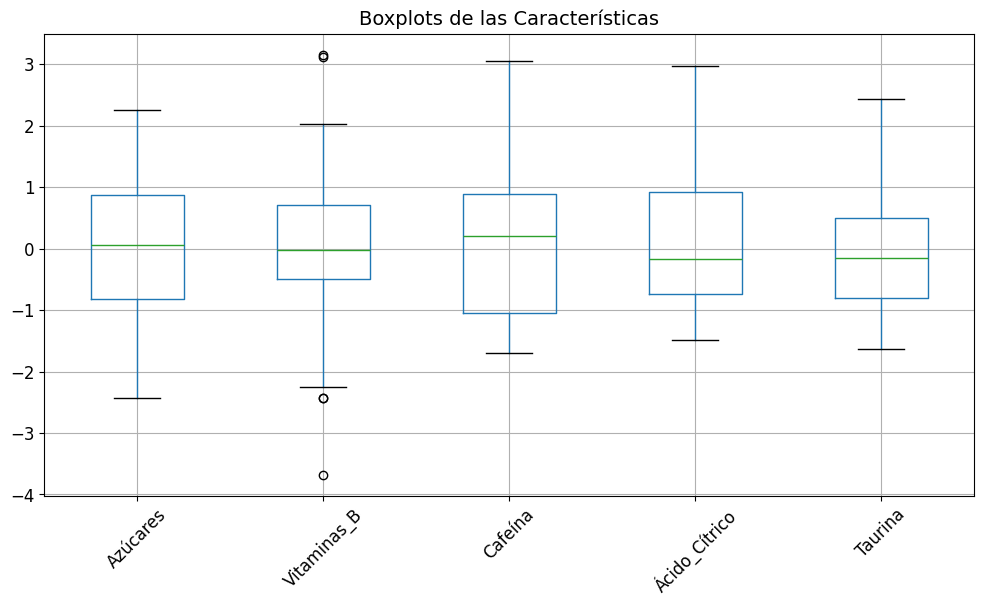

In [3]:
# Configuración de tamaño de gráficos
plt.figure(figsize=(12, 6))

# Histogramas de cada variable
df.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Distribución de las Características", fontsize=16)
plt.show()

# Matriz de Correlación
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=14)
plt.show()

# Boxplots para detectar valores atípicos
plt.figure(figsize=(12, 6))
df.boxplot()
plt.title("Boxplots de las Características", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [6]:
# Resumen de las estadísticas de cada variable
print("Resumen Estadístico de los Datos:")
print(df.describe())

# Calcular cuartiles y rangos intercuartiles (IQR) para detectar valores atípicos
Q1 = df.quantile(0.25)  # Primer cuartil (Q1)
Q3 = df.quantile(0.75)  # Tercer cuartil (Q3)
IQR = Q3 - Q1  # Rango intercuartil (IQR)

print("\nValores Intercuartiles (IQR):")
print(IQR)

# Identificar valores atípicos (fuera de 1.5 * IQR)
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("\nCantidad de valores atípicos por variable:")
print(outliers)

# Ver ejemplos de posibles valores atípicos (si los hay)
print("\nEjemplos de valores atípicos detectados:")
print(df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))].dropna(how='all').head(10))

Resumen Estadístico de los Datos:
         Azúcares  Vitaminas_B     Cafeína  Ácido_Cítrico     Taurina
count  153.000000   153.000000  153.000000     153.000000  153.000000
mean     0.019231     0.037273    0.041057       0.080022   -0.044088
std      1.026182     0.995984    1.040928       1.009450    0.934399
min     -2.434235    -3.679162   -1.695971      -1.493188   -1.634288
25%     -0.816038    -0.499016   -1.043392      -0.738463   -0.799428
50%      0.061000    -0.023821    0.211566      -0.165254   -0.154899
75%      0.876275     0.707247    0.894264       0.917474    0.493956
max      2.259772     3.156325    3.062832       2.971473    2.431870

Valores Intercuartiles (IQR):
Azúcares         1.692313
Vitaminas_B      1.206263
Cafeína          1.937656
Ácido_Cítrico    1.655937
Taurina          1.293384
dtype: float64

Cantidad de valores atípicos por variable:
Azúcares         0
Vitaminas_B      5
Cafeína          0
Ácido_Cítrico    0
Taurina          0
dtype: int64

Ejemplo

vamos a mantener los valores atipicos


Cantidad de clusters encontrados (DBSCAN):
Cluster_DBSCAN
 0    49
 1    42
 2    34
-1    28
Name: count, dtype: int64


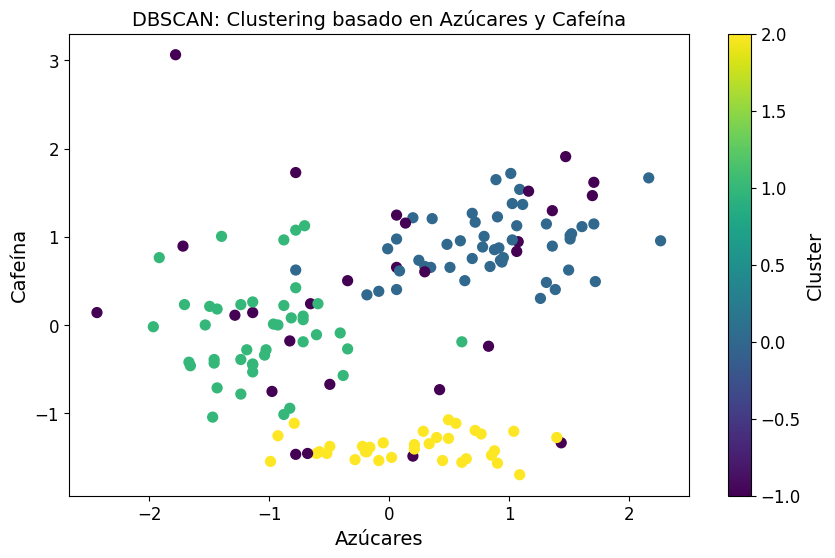

In [9]:
from sklearn.cluster import DBSCAN
import numpy as np

# Aplicar DBSCAN con hiperparámetros iniciales
dbscan = DBSCAN(eps=1.0, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(df)

# Visualizar la cantidad de clusters generados
print("\nCantidad de clusters encontrados (DBSCAN):")
print(df['Cluster_DBSCAN'].value_counts())

# Visualizar los clusters (Scatter plot para dos dimensiones)
plt.figure(figsize=(10, 6))
plt.scatter(df['Azúcares'], df['Cafeína'], c=df['Cluster_DBSCAN'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title("DBSCAN: Clustering basado en Azúcares y Cafeína", fontsize=14)
plt.xlabel("Azúcares")
plt.ylabel("Cafeína")
plt.show()


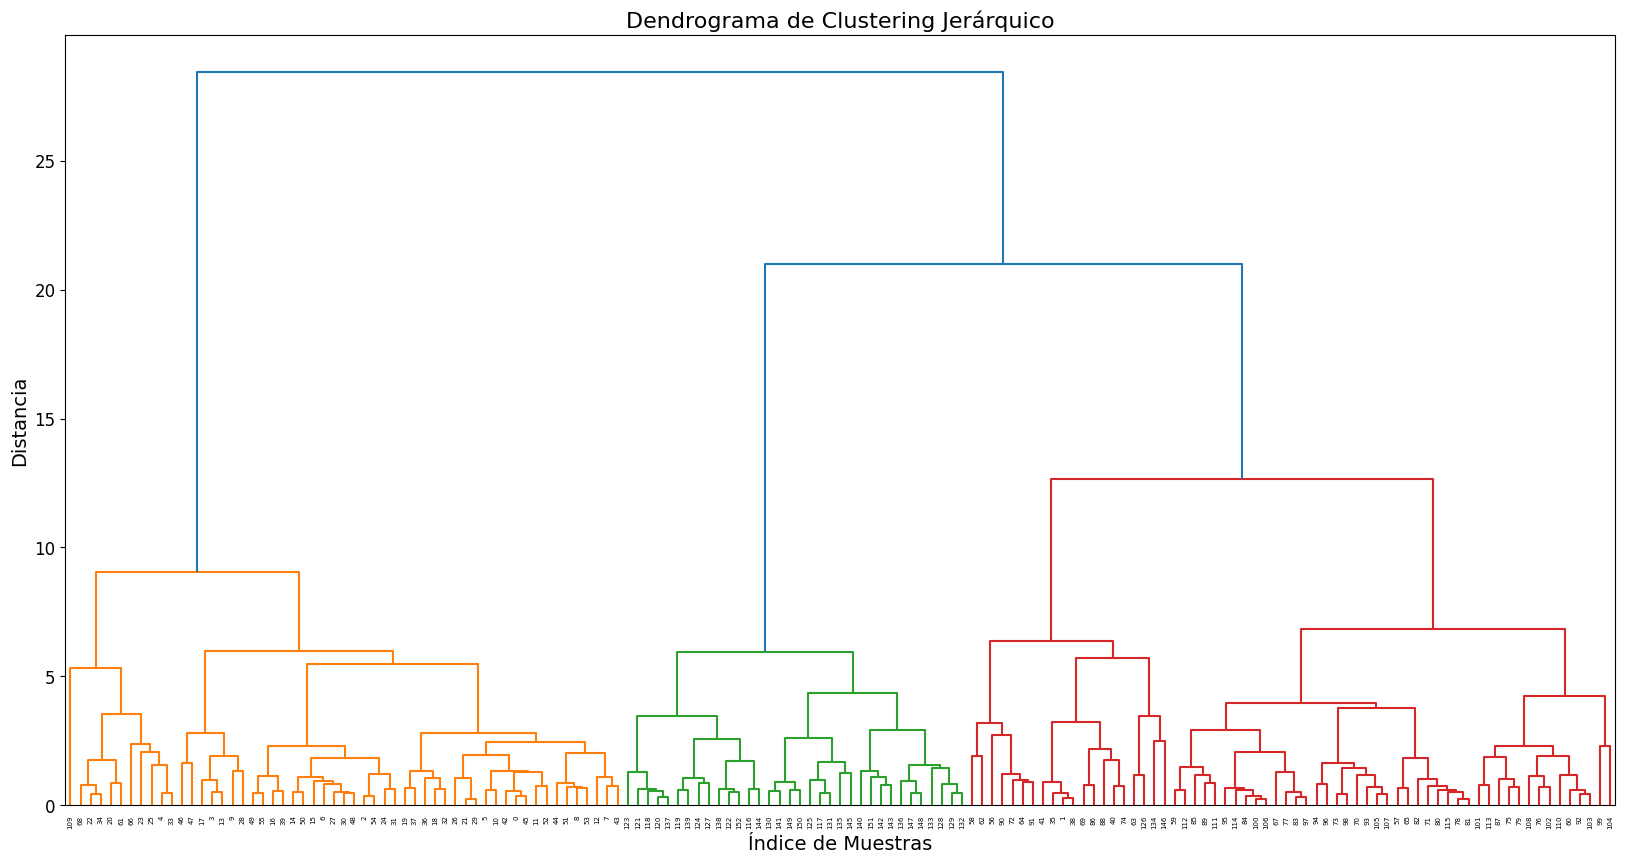

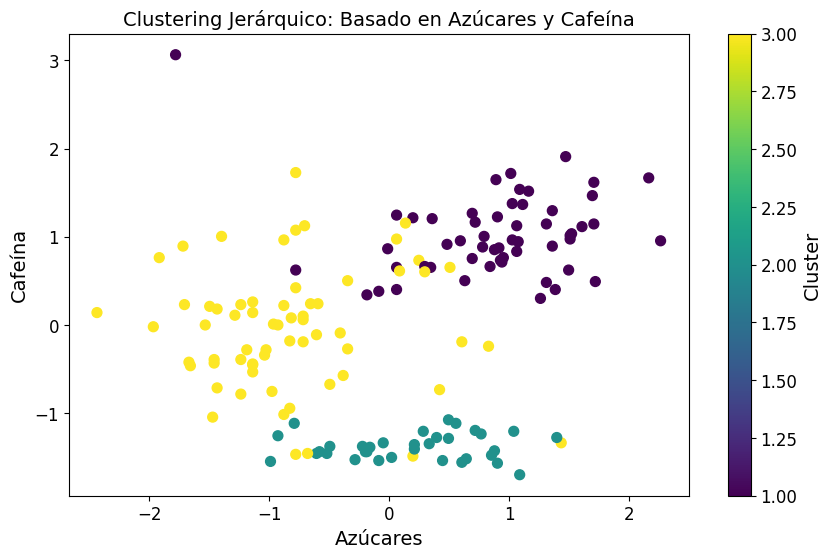

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Generar el linkage para clustering jerárquico
linkage_matrix = linkage(df, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix)
plt.title("Dendrograma de Clustering Jerárquico", fontsize=16)
plt.xlabel("Índice de Muestras")
plt.ylabel("Distancia")
plt.show()

# Cortar el dendrograma para obtener 3 clusters
clusters_jerarquico = fcluster(linkage_matrix, 3, criterion='maxclust')
df['Cluster_Jerarquico'] = clusters_jerarquico

# Visualizar los clusters obtenidos (Scatter plot para dos dimensiones)
plt.figure(figsize=(10, 6))
plt.scatter(df['Azúcares'], df['Cafeína'], c=df['Cluster_Jerarquico'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title("Clustering Jerárquico: Basado en Azúcares y Cafeína", fontsize=14)
plt.xlabel("Azúcares")
plt.ylabel("Cafeína")
plt.show()

In [23]:
from sklearn.cluster import DBSCAN

# Probar diferentes valores de eps y min_samplespara podder reducir el ruido 
for eps_value in [0.5, 0.8, 1.0, 1.2]:
    for min_samples_value in [3, 5, 8]:
        # Crear modelo DBSCAN 
        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        df['Cluster_DBSCAN'] = dbscan.fit_predict(df)
        
        # Contar la cantidad de clusters y puntos de ruido
        cluster_counts = df['Cluster_DBSCAN'].value_counts()
        noise_points = (df['Cluster_DBSCAN'] == -1).sum()

        # Mostrar resultados
        print(f"\neps = {eps_value}, min_samples = {min_samples_value}")
        print(f"Cantidad de clusters: {len(cluster_counts) - (1 if -1 in cluster_counts.index else 0)}")
        print(f"Puntos de ruido: {noise_points}")



eps = 0.5, min_samples = 3
Cantidad de clusters: 8
Puntos de ruido: 125

eps = 0.5, min_samples = 5
Cantidad de clusters: 0
Puntos de ruido: 153

eps = 0.5, min_samples = 8
Cantidad de clusters: 0
Puntos de ruido: 153

eps = 0.8, min_samples = 3
Cantidad de clusters: 7
Puntos de ruido: 54

eps = 0.8, min_samples = 5
Cantidad de clusters: 8
Puntos de ruido: 80

eps = 0.8, min_samples = 8
Cantidad de clusters: 2
Puntos de ruido: 122

eps = 1.0, min_samples = 3
Cantidad de clusters: 10
Puntos de ruido: 18

eps = 1.0, min_samples = 5
Cantidad de clusters: 7
Puntos de ruido: 39

eps = 1.0, min_samples = 8
Cantidad de clusters: 4
Puntos de ruido: 88

eps = 1.2, min_samples = 3
Cantidad de clusters: 10
Puntos de ruido: 14

eps = 1.2, min_samples = 5
Cantidad de clusters: 7
Puntos de ruido: 34

eps = 1.2, min_samples = 8
Cantidad de clusters: 4
Puntos de ruido: 53


eps = 1.0 y min_samples = 3:
- Proporciona 10 clusters y muy poco ruido (18 puntos).

eps = 1.0 y min_samples = 5:
- Genera 7 clusters con 39 puntos de ruido.




Resultados de DBSCAN (Parámetros ajustados):
Cluster_DBSCAN
 0    43
-1    34
 3    29
 6    15
 5     6
 4     5
 2     5
 7     5
 1     4
 8     4
 9     3
Name: count, dtype: int64


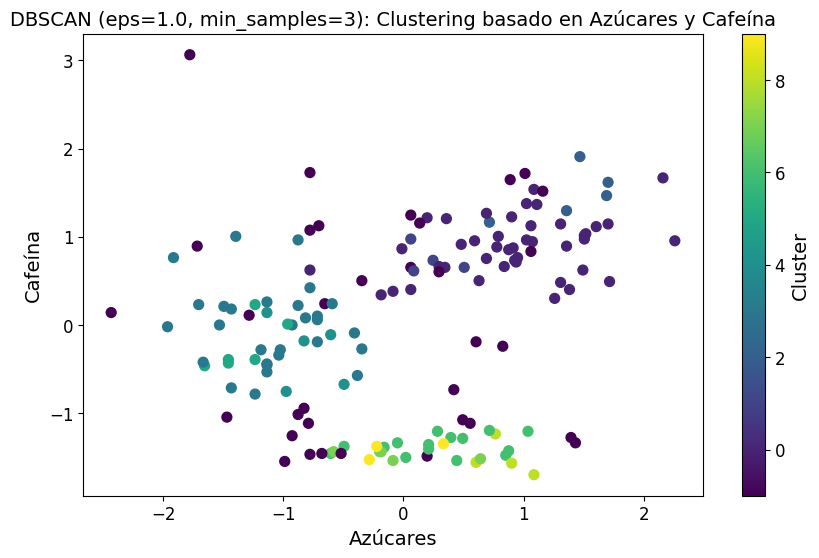

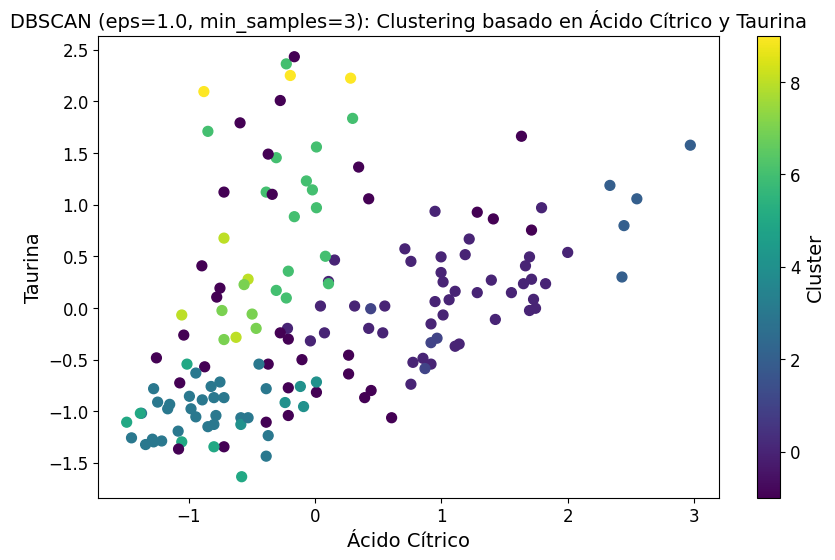

In [24]:
# parametros ajustados
dbscan = DBSCAN(eps=1.0, min_samples=3)
df['Cluster_DBSCAN'] = dbscan.fit_predict(df)

# Contar los clusters y puntos de ruido
print("\nResultados de DBSCAN (Parámetros ajustados):")
print(df['Cluster_DBSCAN'].value_counts())

# Visualización de los clusters ajustados (Scatter plot para Azúcares vs Cafeína)
plt.figure(figsize=(10, 6))
plt.scatter(df['Azúcares'], df['Cafeína'], c=df['Cluster_DBSCAN'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title("DBSCAN (eps=1.0, min_samples=3): Clustering basado en Azúcares y Cafeína", fontsize=14)
plt.xlabel("Azúcares")
plt.ylabel("Cafeína")
plt.show()

# Visualización adicional: Clustering en Ácido Cítrico vs Taurina
plt.figure(figsize=(10, 6))
plt.scatter(df['Ácido_Cítrico'], df['Taurina'], c=df['Cluster_DBSCAN'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title("DBSCAN (eps=1.0, min_samples=3): Clustering basado en Ácido Cítrico y Taurina", fontsize=14)
plt.xlabel("Ácido Cítrico")
plt.ylabel("Taurina")
plt.show()


Clusters generados:
- Cantidad total: 10 clusters.

Distribución:
- Cluster 0: 43 puntos (principal).
- Cluster 3: 29 puntos (secundario).
- Otros clusters tienen menos puntos, entre 3 y 15.

Puntos de ruido (-1):
- 34 puntos identificados como ruido.
- Representa una mejora significativa respecto a configuraciones previas con mayor cantidad de ruido.

Visualizaciones:
- Se puede ver que en Azúcares vs Cafeína: Los clusters están bien separados con varios segmentos pequeños.
- Y en este gráfico de Ácido Cítrico vs Taurina: Los clusters también muestran separaciones claras, aunque algunos puntos podrían agruparse mejor con ajustes adicionales.

Análisis y conclusiones
- Reducción del ruido: Esta configuración (eps=1.0 y min_samples=3) permite una segmentación detallada con poco ruido (34 puntos). Es una mejora respecto a configuraciones previas.
- Clusters significativos: Los clusters más grandes (como 0, 3 y 6) agrupan la mayor parte de los datos, mientras que los demás representan grupos más pequeños.
- Limitaciones: Algunos clusters pequeños (1, 8, 9) tienen muy pocos puntos (3-5), lo que puede hacerlos menos útiles para el análisis.

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [25]:
# Cargar los nuevos experimentos
file_path_new_experiments = r"C:\Users\migue\Documents\GitHub\ONLINE_DS_THEBRIDGE_Miguel_repo_test\Sprint_13\Unidad_02\Practica_Obligatoria\data\new_experiments.csv"
df_new_experiments = pd.read_csv(file_path_new_experiments)

# Separar las columnas correctamente
columns = ["Azúcares", "Vitaminas_B", "Cafeína", "Ácido_Cítrico", "Taurina"]
df_new_experiments[columns] = df_new_experiments.iloc[:, 0].str.split('|', expand=True).astype(float)
df_new_experiments.drop(columns=df_new_experiments.columns[0], inplace=True)

# Aplicar DBSCAN al nuevo conjunto de datos
df_new_experiments['Cluster_DBSCAN'] = dbscan.fit_predict(df_new_experiments)

# Mostrar resultados
print("Resultados de clasificación de los nuevos experimentos:")
print(df_new_experiments['Cluster_DBSCAN'].value_counts())

Resultados de clasificación de los nuevos experimentos:
Cluster_DBSCAN
-1    6
Name: count, dtype: int64


c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

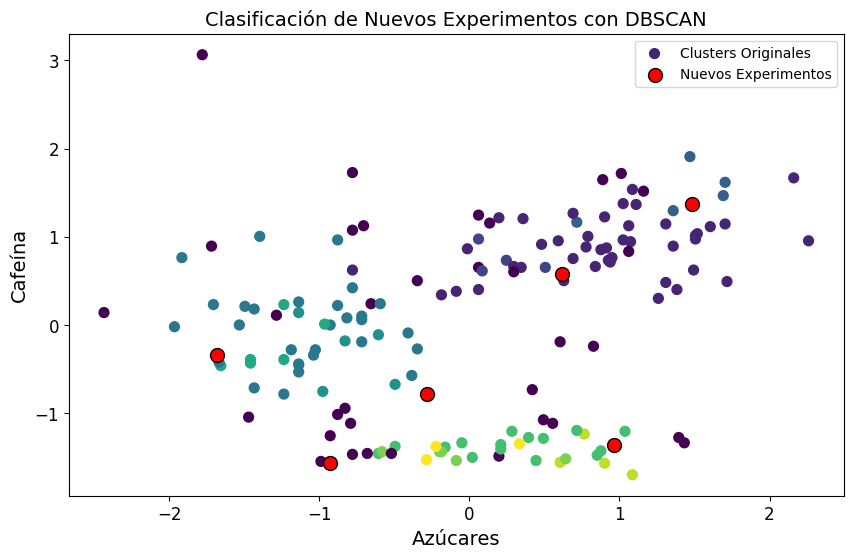

In [26]:
# Visualizar los nuevos experimentos en el espacio de Azúcares y Cafeína
plt.figure(figsize=(10, 6))
plt.scatter(df['Azúcares'], df['Cafeína'], c=df['Cluster_DBSCAN'], cmap='viridis', s=50, label='Clusters Originales')
plt.scatter(df_new_experiments['Azúcares'], df_new_experiments['Cafeína'], c='red', s=100, label='Nuevos Experimentos', edgecolors='black')
plt.legend()
plt.title("Clasificación de Nuevos Experimentos con DBSCAN", fontsize=14)
plt.xlabel("Azúcares")
plt.ylabel("Cafeína")
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler

# Escalar los datos de los nuevos experimentos
scaler = StandardScaler()
df_new_experiments_scaled = scaler.fit_transform(df_new_experiments)

# Parámetros de DBSCAN
dbscan_adjusted = DBSCAN(eps=1.5, min_samples=2)
df_new_experiments['Cluster_DBSCAN'] = dbscan_adjusted.fit_predict(df_new_experiments_scaled)

# Mostrar resultados ajustados
print("Resultados ajustados de clasificación de los nuevos experimentos:")
print(df_new_experiments['Cluster_DBSCAN'].value_counts())

Resultados ajustados de clasificación de los nuevos experimentos:
Cluster_DBSCAN
-1    4
 0    2
Name: count, dtype: int64


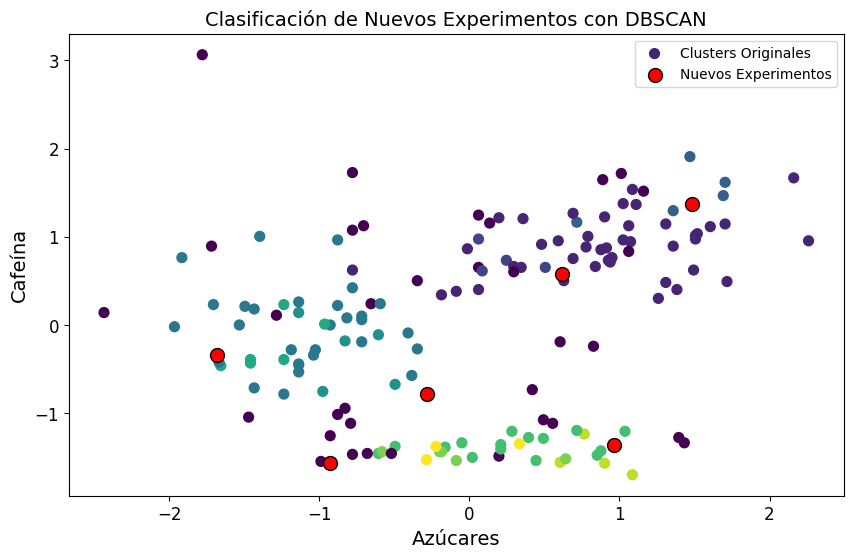

In [28]:
# Visualizar los nuevos experimentos en el espacio de Azúcares y Cafeína
plt.figure(figsize=(10, 6))
plt.scatter(df['Azúcares'], df['Cafeína'], c=df['Cluster_DBSCAN'], cmap='viridis', s=50, label='Clusters Originales')
plt.scatter(df_new_experiments['Azúcares'], df_new_experiments['Cafeína'], c='red', s=100, label='Nuevos Experimentos', edgecolors='black')
plt.legend()
plt.title("Clasificación de Nuevos Experimentos con DBSCAN", fontsize=14)
plt.xlabel("Azúcares")
plt.ylabel("Cafeína")
plt.show()

In [30]:
dbscan_adjusted = DBSCAN(eps=1.8, min_samples=2)
df_new_experiments['Cluster_DBSCAN'] = dbscan_adjusted.fit_predict(df_new_experiments_scaled)

print("Nuevos resultados con parámetros ajustados:")
print(df_new_experiments['Cluster_DBSCAN'].value_counts())

Nuevos resultados con parámetros ajustados:
Cluster_DBSCAN
-1    4
 0    2
Name: count, dtype: int64


In [31]:
dbscan_adjusted = DBSCAN(eps=2.0, min_samples=2)
df_new_experiments['Cluster_DBSCAN'] = dbscan_adjusted.fit_predict(df_new_experiments_scaled)

print("Resultados con eps=2.0:")
print(df_new_experiments['Cluster_DBSCAN'].value_counts())

Resultados con eps=2.0:
Cluster_DBSCAN
-1    4
 0    2
Name: count, dtype: int64


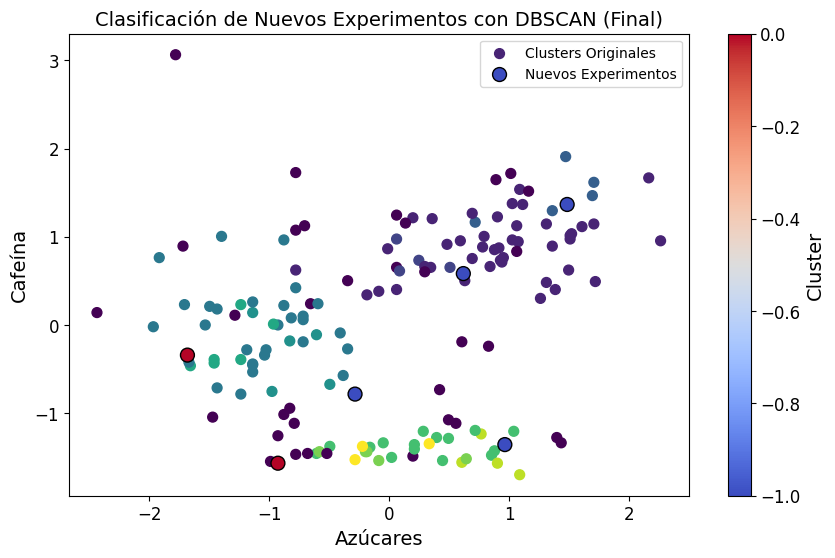

In [32]:
# Visualización de los nuevos experimentos junto a los clusters originales
plt.figure(figsize=(10, 6))
plt.scatter(df['Azúcares'], df['Cafeína'], c=df['Cluster_DBSCAN'], cmap='viridis', s=50, label='Clusters Originales')
plt.scatter(
    df_new_experiments['Azúcares'], 
    df_new_experiments['Cafeína'], 
    c=df_new_experiments['Cluster_DBSCAN'], 
    cmap='coolwarm', 
    s=100, 
    edgecolors='black', 
    label='Nuevos Experimentos'
)
plt.colorbar(label='Cluster')
plt.legend()
plt.title("Clasificación de Nuevos Experimentos con DBSCAN (Final)", fontsize=14)
plt.xlabel("Azúcares")
plt.ylabel("Cafeína")
plt.show()


- 2 experimentos fueron asignados al Cluster 0, lo que indica que están relacionados con combinaciones de ingredientes similares a las del cluster original.
- 4 experimentos fueron clasificados como ruido (Cluster = -1), lo que significa que no tienen suficientes vecinos cercanos para ser agrupados con los clusters existentes.

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.